# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch.nn as nn
import math as math
from torchviz import make_dot
import time

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
                                          cost_fn_fact, 
                                          calculate_hot_start_data
                                          )

from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model,
                                         set_up_input_no_hot_start,
                                         set_up_input_hot_start,
                                         )

from modules.graph_functions import plot_sine_activation

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

from modules.config import PRINT_FREQUENCY

Set up constants:

In [2]:
datalogger = MyDataLogger()
sdl = MySubDataLogger(runid = datalogger.runid)
sdl.update_general_constants_from_config()
sdl.update_ml_constants_from_config()
sdl.validate_input()

SubDataLogger instantiated.  Run ID = 20251129-12-55-51 - 12-55-51


Read in data, report on data read and validate distance array:

In [3]:
distance_array, sdl.best_dist = find_distances_array(sdl.locations, print_comments=True)

Reading distance data
Data will be read from filename networks\four_d.txt.
It is known that the shortest distance is 21


Evaluate cost function and clear cache:

In [4]:
cost_fn = cost_fn_fact(sdl, distance_array)
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [5]:
device = find_device()
print(f"Using device: {device}")

Using device: cpu


Find problem size:

In [6]:
sdl.qubits = find_problem_size(sdl)
print(f'There are {sdl.qubits} qubits needed for {sdl.locations} locations in the {sdl.formulation} formulation.')

There are 3 qubits needed for 4 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [7]:
if sdl.hot_start:
    bin_hot_start_list, sdl.hot_start_dist = calculate_hot_start_data(sdl, 
                                                                    distance_array,
                                                                    cost_fn,
                                                                    print_results=True,
                                                                    )
    _, my_input  = set_up_input_hot_start(sdl,
                                        device,
                                        bin_hot_start_list,
                                        )
else:
    _, my_input  = set_up_input_no_hot_start(sdl, device)
    sdl.hot_start_dist = 'n/a'

Set up input as repeated hot start tensor calculated above:

Set up model with gradient required:

In [8]:
model = MyModel(sdl, cost_fn).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [9]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 12 parameters in total, of which 12 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

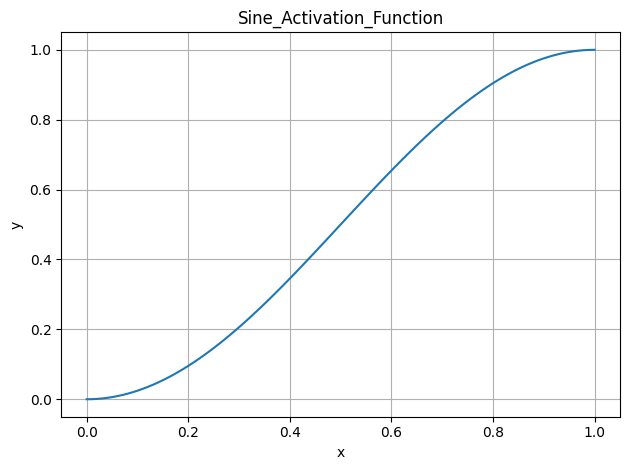

In [10]:
plot_sine_activation()

Print out model details including graph

{'fc1.weight': Parameter containing:
tensor([[-0.0633, -0.3338,  0.2596],
        [ 0.0406, -0.2815, -0.2551],
        [ 0.0441,  0.2200,  0.5530]], requires_grad=True), 'fc1.bias': Parameter containing:
tensor([-0.1135, -0.3402,  0.2841], requires_grad=True)}


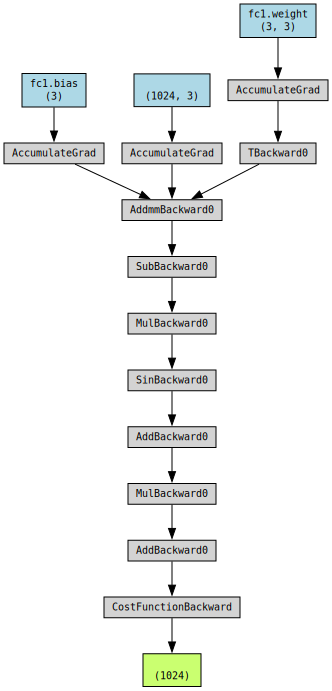

In [11]:
output = model(my_input)
lowest_cost = output.min()
filename = sdl.graph_sub_path.joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
#make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict).render(filename, format="pdf")
make_dot(output, params=param_dict)

Set up criterion, optimizer and target ready to train model.

In [12]:
target, criterion, optimizer = get_ready_to_train(sdl, model,)

Train model and print out results:

In [13]:

t0 = time.time()
sdl.best_dist_found, sdl.iteration_found, sdl.index_list, sdl.average_list, sdl.lowest_list =\
    train_model(sdl.iterations,
                model, 
                my_input, 
                target, 
                criterion,
                optimizer,
                print_results=True,
                print_frequency=PRINT_FREQUENCY
                )

sdl.average_list_all.append(sdl.average_list)
sdl.lowest_list_all.append(sdl.lowest_list)
t1 = time.time()
elapsed = t1-t0
print(f'The time taken to run the code is {elapsed:.3f} seconds')
sdl.elapsed = elapsed
sdl.update_cache_statistics(cost_fn)
sdl.save_results_to_csv()
sdl.save_detailed_results()

c:\Users\DanielGoldsmith\python_notebooks\TSP_VQC\modules\helper_ML_functions.py:65: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  lowest_cost = float(model_output.min())


Epoch 0, Average cost: 21.875 Epoch min cost:21.000, Lowest Cost to date: 21.000
Epoch 0, fc1.weight grad: 0.00
Epoch 0, fc1.bias grad: 4629.01
The time taken to run the code is 5.339 seconds
Saving data to results\results.csv
Detailed data for Run ID: 20251129-12-55-51 - 12-55-51 successfully added to results\20251129-12-55-51\12-55-51.csv


In [14]:
print(f'The lowest cost found was {sdl.best_dist_found:.3f} at epoch {sdl.iteration_found}.')
print(f'The best known cost is {sdl.best_dist:.3f}')
if sdl.hot_start:
    print(f'the hot start cost was {sdl.hot_start_dist:.3f}.')

The lowest cost found was 21.000 at epoch 0.
The best known cost is 21.000


Plot loss ratio by epoch:

Graph for Run ID: 20251129-12-55-51-12-55-51 being saved to graphs\20251129-12-55-51\12-55-51.png


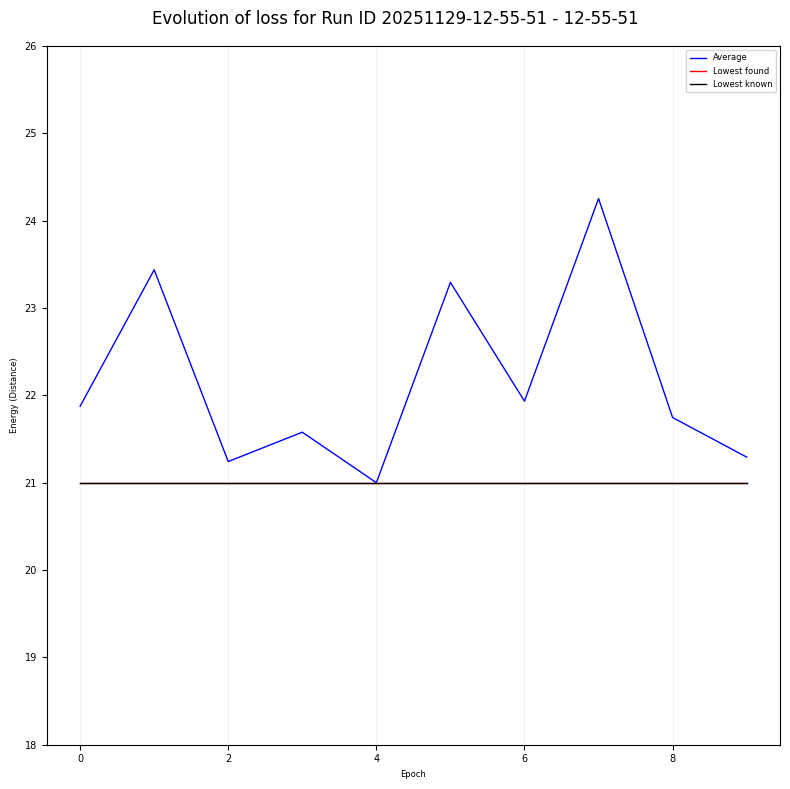

In [15]:
sdl.save_plot()

Print out parameters:

In [16]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[-0.0633, -0.3338,  0.2595],
        [ 0.0406, -0.2815, -0.2551],
        [ 0.0441,  0.2200,  0.5530]], requires_grad=True)
bias: Parameter containing:
tensor([-32.8364,  71.1731, -44.6136], requires_grad=True)
